# Flooding Packets

In [1]:
# brew install nmap

## Flooding ICMP packets

In [2]:
# sudo ping -f 192.168.29.255

## Flooding TCP SYN packets (10,000)

In [3]:
# sudo nping --tcp -p 80 --flags syn --rate 1000 -c 10000 192.168.1.1

## Flooding UDP packets (10,000)

In [4]:
# sudo nping --udp -p 53 --rate 1000 -c 10000 192.168.1.1

# Converting the pcap file to csv file

In [ ]:
from scapy.all import rdpcap, IP, IPv6, UDP, TCP, ICMP, DHCP, BOOTP
import pandas as pd

# Read PCAP file
packets = rdpcap("DHCP_starvaation.pcapng")
# packets = rdpcap("file1.pcapng")

data = []
for pkt in packets:
    row = {
        "SYN_Packet": 0,  # Default to 0 (Not a SYN packet)
        "time": pkt.time,
        "src": None,
        "dst": None,
        "proto": None,
        "src_port": None,
        "dst_port": None,
        "length": len(pkt)
    }

    # Check if packet has IPv4 or IPv6
    if pkt.haslayer(IP):
        row["src"] = pkt[IP].src
        row["dst"] = pkt[IP].dst
        proto_number = pkt[IP].proto
    elif pkt.haslayer(IPv6):
        row["src"] = pkt[IPv6].src
        row["dst"] = pkt[IPv6].dst
        proto_number = "UDP" if pkt.haslayer(UDP) else "Other"
    else:
        proto_number = None

    # Convert protocol number to name
    proto_mapping = {1: "ICMP", 6: "TCP", 17: "UDP"}
    row["proto"] = proto_mapping.get(proto_number, proto_number)  # Keep unknown proto as is

    # Check for UDP/TCP and extract ports
    if pkt.haslayer(UDP):
        row["src_port"] = pkt[UDP].sport
        row["dst_port"] = pkt[UDP].dport
    elif pkt.haslayer(TCP):
        row["src_port"] = pkt[TCP].sport
        row["dst_port"] = pkt[TCP].dport
        
        # Detect SYN packet (SYN flag should be set and ACK flag should be absent)
        flags = int(pkt[TCP].flags)
        row["SYN_Packet"] = 1 if (flags & 0x02 and not (flags & 0x10)) else 0

    # Detect DHCP messages
    if pkt.haslayer(DHCP):
        dhcp_options = pkt[DHCP].options
        for opt in dhcp_options:
            if isinstance(opt, tuple) and opt[0] == "message-type":
                dhcp_type = {1: "DISCOVER", 2: "OFFER", 3: "REQUEST", 5: "ACK"}.get(opt[1], "DHCP")
                row["proto"] = dhcp_type  # Set DHCP message type as protocol

    data.append(row)

# Convert to CSV
df = pd.DataFrame(data)
df.to_csv("output.csv", index=False)
print("CSV file saved with SYN packet detection!")

CSV file saved with SYN packet detection!


In [2]:
import csv

# Read the CSV file
df = pd.read_csv("output.csv")

# Display the first few rows
df

,SYN_Packet,time,src,dst,proto,src_port,dst_port,length
0,0,1.747321e+09,2a04:4e42:8d::684,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,Other,443.0,51288.0,1514
1,0,1.747321e+09,2a04:4e42:8d::684,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,Other,443.0,51288.0,1514
2,0,1.747321e+09,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:8d::684,Other,51288.0,443.0,86
3,0,1.747321e+09,2a04:4e42:8d::684,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,Other,443.0,51288.0,1514
4,0,1.747321e+09,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:8d::684,Other,51288.0,443.0,86
...,...,...,...,...,...,...,...,...
1156674,0,1.747323e+09,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a03:2880:f349:121:face:b00c:0:7260,Other,51147.0,443.0,86
1156675,0,1.747323e+09,2a03:2880:f349:121:face:b00c:0:7260,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,Other,443.0,51147.0,143
1156676,0,1.747323e+09,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a03:2880:f349:121:face:b00c:0:7260,Other,51147.0,443.0,86
1156677,0,1.747323e+09,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a03:2880:f349:121:face:b00c:0:7260,Other,51147.0,443.0,137


# Dropping unwanted columns

In [43]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("output.csv")

# Drop unwanted columns
df.drop(columns=["time", "src_port", "dst_port", "length"], inplace=True)

# Save the updated CSV
df.to_csv("output.csv", index=False)

print("Updated CSV saved as 'output.csv'!")

Updated CSV saved as 'output.csv'!


In [44]:
df

,SYN_Packet,src,dst,proto
0,0,2a04:4e42:8d::684,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,Other
1,0,2a04:4e42:8d::684,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,Other
2,0,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:8d::684,Other
3,0,2a04:4e42:8d::684,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,Other
4,0,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:8d::684,Other
...,...,...,...,...
1156674,0,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a03:2880:f349:121:face:b00c:0:7260,Other
1156675,0,2a03:2880:f349:121:face:b00c:0:7260,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,Other
1156676,0,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a03:2880:f349:121:face:b00c:0:7260,Other
1156677,0,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a03:2880:f349:121:face:b00c:0:7260,Other


# Counting the number of packets

In [45]:
# Group by 'SYN', 'src', 'dst', and 'proto', then count occurrences
df_grouped = df.groupby(["SYN_Packet", "src", "dst", "proto"], as_index=False).size()

# Group by 'SYN', 'src', 'dst', and 'proto' and count the number of occurrences
df_grouped = df.groupby(["SYN_Packet", "src", "dst", "proto"]).size().reset_index(name="count")

# Save the updated CSV
df_grouped.to_csv("output.csv", index=False)

print("Grouped CSV saved as 'output.csv'!")

Grouped CSV saved as 'output.csv'!


In [46]:
df_grouped

,SYN_Packet,src,dst,proto,count
0,0,100.20.37.90,192.168.29.222,TCP,185
1,0,104.18.2.144,192.168.29.222,TCP,9
2,0,104.18.3.144,192.168.29.222,TCP,9
3,0,104.199.241.202,192.168.29.222,TCP,52
4,0,104.208.16.90,192.168.29.222,TCP,43
...,...,...,...,...,...
718,1,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:8d::760,Other,4
719,1,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:8e::760,Other,1
720,1,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:8e::763,Other,1
721,1,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:9::684,Other,1


# Categorizing the data if it is attack or not

In [47]:
import pandas as pd

# Load the dataset (use raw dataset instead of grouped output.csv)
df = pd.read_csv("output.csv")

# Group by 'SYN_Packet', 'src', 'dst', and 'proto', then count occurrences
df_grouped = df.groupby(["SYN_Packet", "src", "dst", "proto"])["count"].sum().reset_index()

# Calculate the mean count for UDP packets
udp_mean_count = df_grouped[df_grouped["proto"] == "UDP"]["count"].mean()

# Define attack criteria
def detect_attack(row):
    if row["proto"] == "DISCOVER" and row["count"] > 150:
        return 1  # Attack due to high DISCOVER traffic
    if row["SYN_Packet"] == 1 and row["count"] > 100:
        return 1  # Possible DDoS attack
    if row["proto"] == "ICMP" and row["count"] > 150:
        return 1  # ICMP flood attack
    if row["proto"] == "UDP" and row["count"] > udp_mean_count:
        return 1  # High UDP traffic attack
    return 0  # Normal traffic

# Apply the attack detection function
df_grouped["attack"] = df_grouped.apply(detect_attack, axis=1)

# Save the updated CSV
df_grouped.to_csv("output.csv", index=False)

print("Grouped CSV with attack column saved as 'output.csv'!")

Grouped CSV with attack column saved as 'output.csv'!


In [48]:
df_grouped

,SYN_Packet,src,dst,proto,count,attack
0,0,100.20.37.90,192.168.29.222,TCP,185,0
1,0,104.18.2.144,192.168.29.222,TCP,9,0
2,0,104.18.3.144,192.168.29.222,TCP,9,0
3,0,104.199.241.202,192.168.29.222,TCP,52,0
4,0,104.208.16.90,192.168.29.222,TCP,43,0
...,...,...,...,...,...,...
718,1,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:8d::760,Other,4,0
719,1,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:8e::760,Other,1,0
720,1,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:8e::763,Other,1,0
721,1,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,2a04:4e42:9::684,Other,1,0


# Encoding dataset - Converting the values to numerical form

In [50]:
# Step 1: Read the CSV file
df_grouped = pd.read_csv("output.csv")

# Step 2: Encode 'proto' column and place it next to 'proto'
proto_map = {'TCP': 0, 'UDP': 1, 'ICMP': 2, 'DISCOVER': 3, 'Other': 4}
df_grouped.insert(df_grouped.columns.get_loc("proto") + 1, "proto_encoded", df_grouped["proto"].map(proto_map))

# Step 3: Encode 'src' and place it next to 'src'
df_grouped.insert(df_grouped.columns.get_loc("src") + 1, "src_encoded", df_grouped["src"].astype('category').cat.codes)

# Step 4: Encode 'dst' and place it next to 'dst'
df_grouped.insert(df_grouped.columns.get_loc("dst") + 1, "dst_encoded", df_grouped["dst"].astype('category').cat.codes)

# Step 5: Save the formatted dataset
df_grouped.to_csv("output.csv", index=False)

# Step 6: Display the first few rows
df_grouped

ValueError: cannot insert proto_encoded, already exists

# Min-Max Scaling

In [52]:
# Step 1: Select only numerical columns for scaling
numerical_columns = df_grouped.select_dtypes(include=['number'])

# Step 2: Compute min and max for each numerical feature
min_max_values = numerical_columns.agg(['min', 'max']).transpose().reset_index()

# Step 3: Rename columns for clarity
min_max_values.columns = ['Feature', 'Min', 'Max']

# Step 4: Display the Min-Max values
min_max_values

,Feature,Min,Max
0,SYN_Packet,0.0,1.0
1,src_encoded,0.0,238.0
2,dst_encoded,0.0,249.0
3,proto_encoded,0.0,4.0
4,count,1.0,655079.0
5,attack,0.0,1.0


# Normalizing the data

In [53]:
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv("output.csv")

# Select the columns to normalize
columns_to_normalize = ["SYN_Packet", "src_encoded", "dst_encoded", "proto_encoded", "count"]

# Apply Min-Max Scaling
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Save the normalized dataset
df.to_csv("normalized_output.csv", index=False)

# Display first few rows
df

,SYN_Packet,src,src_encoded,dst,dst_encoded,proto,proto_encoded,count,attack
0,0.0,100.20.37.90,0.000000,192.168.29.222,0.124498,TCP,0.0,0.000281,0
1,0.0,104.18.2.144,0.004202,192.168.29.222,0.124498,TCP,0.0,0.000012,0
2,0.0,104.18.3.144,0.008403,192.168.29.222,0.124498,TCP,0.0,0.000012,0
3,0.0,104.199.241.202,0.012605,192.168.29.222,0.124498,TCP,0.0,0.000078,0
4,0.0,104.208.16.90,0.016807,192.168.29.222,0.124498,TCP,0.0,0.000064,0
...,...,...,...,...,...,...,...,...,...
718,1.0,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,0.361345,2a04:4e42:8d::760,0.783133,Other,1.0,0.000005,0
719,1.0,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,0.361345,2a04:4e42:8e::760,0.787149,Other,1.0,0.000000,0
720,1.0,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,0.361345,2a04:4e42:8e::763,0.791165,Other,1.0,0.000000,0
721,1.0,2405:201:5c1b:b89b:c937:fe63:6939:7fcc,0.361345,2a04:4e42:9::684,0.795181,Other,1.0,0.000000,0


# Calculate prior probablities

In [54]:
import pandas as pd

# Load dataset
df = pd.read_csv("normalized_output.csv")

# Total number of rows
total = len(df)

# Number of attack and normal packets
attack_count = df[df["attack"] == 1].shape[0]
normal_count = df[df["attack"] == 0].shape[0]

# Prior probabilities
p_attack = attack_count / total
p_normal = normal_count / total

print(f"P(attack) = {attack_count}/{total} = {p_attack:.4f}")
print(f"P(normal) = {normal_count}/{total} = {p_normal:.4f}")

P(attack) = 13/723 = 0.0180
P(normal) = 710/723 = 0.9820


# Calculate the conditional probablities after Laplace Smoothing

In [55]:
df = pd.read_csv("normalized_output.csv")
df.head()

,SYN_Packet,src,src_encoded,dst,dst_encoded,proto,proto_encoded,count,attack
0,0.0,100.20.37.90,0.000000,192.168.29.222,0.124498,TCP,0.0,0.000281,0
1,0.0,104.18.2.144,0.004202,192.168.29.222,0.124498,TCP,0.0,0.000012,0
2,0.0,104.18.3.144,0.008403,192.168.29.222,0.124498,TCP,0.0,0.000012,0
3,0.0,104.199.241.202,0.012605,192.168.29.222,0.124498,TCP,0.0,0.000078,0
4,0.0,104.208.16.90,0.016807,192.168.29.222,0.124498,TCP,0.0,0.000064,0


In [56]:
import pandas as pd

# Load the dataset
file_path = "normalized_output.csv"
df = pd.read_csv(file_path)

# Define Laplace smoothing parameters
alpha = 1  # Laplace smoothing factor
N = 2  # Possible values for binary variables (0 and 1)

# General function to compute probabilities with Laplace smoothing
def laplace_smoothing(feature, value, given):
    return (df[(df[feature] == value) & (df["attack"] == given)].shape[0] + alpha) / \
           (df[df["attack"] == given].shape[0] + alpha * df[feature].nunique())

# Compute probabilities for SYN_Packet
probabilities = {
    "P(SYN=1|attack)": laplace_smoothing("SYN_Packet", 1, 1),
    "P(SYN=0|attack)": laplace_smoothing("SYN_Packet", 0, 1),
    "P(SYN=1|normal)": laplace_smoothing("SYN_Packet", 1, 0),
    "P(SYN=0|normal)": laplace_smoothing("SYN_Packet", 0, 0),
}

# Compute probabilities for all unique proto_encoded values
unique_proto_values = df_grouped["proto_encoded"].unique()
for proto in unique_proto_values:
    probabilities[f"P(proto={proto}|attack)"] = laplace_smoothing("proto_encoded", proto, 1)
    probabilities[f"P(proto={proto}|normal)"] = laplace_smoothing("proto_encoded", proto, 0)

# Print the computed probabilities
probabilities

{'P(SYN=1|attack)': 0.13333333333333333,
 'P(SYN=0|attack)': 0.8666666666666667,
 'P(SYN=1|normal)': 0.273876404494382,
 'P(SYN=0|normal)': 0.726123595505618,
 'P(proto=0.0|attack)': 0.11764705882352941,
 'P(proto=0.0|normal)': 0.4103641456582633,
 'P(proto=1.0|attack)': 0.058823529411764705,
 'P(proto=1.0|normal)': 0.4565826330532213,
 'P(proto=2.0|attack)': 0.058823529411764705,
 'P(proto=2.0|normal)': 0.0014005602240896359,
 'P(proto=nan|attack)': 0.058823529411764705,
 'P(proto=nan|normal)': 0.0014005602240896359,
 'P(proto=4.0|attack)': 0.058823529411764705,
 'P(proto=4.0|normal)': 0.0014005602240896359}

In [57]:
# Load data
import pandas as pd
df = pd.read_csv("output.csv")

# Separate counts based on attack label
attack_counts = df[df["attack"] == 1]["count"].tolist()
normal_counts = df[df["attack"] == 0]["count"].tolist()

# Display the lists
print("Attack =", attack_counts)
print("\nNormal =", normal_counts)

Attack = [163, 1047, 171, 40005, 655079, 1041, 1107, 1386, 740, 610, 1445, 760, 10050]

Normal = [185, 9, 9, 52, 43, 14, 15, 24, 7, 4, 17, 1, 9, 1, 292, 290, 31, 40, 108, 153, 99, 224, 42, 15, 3, 25, 26, 17, 28, 109, 81, 9, 42, 56, 47, 16, 13, 238, 14, 13, 70, 51, 16, 21, 20, 11, 6, 17, 1, 10, 1, 247, 328, 39, 38, 108, 160, 182, 135, 103, 21, 2, 36, 28, 15, 45, 115, 19, 63, 47, 78, 12, 71, 71, 665, 24, 16, 14, 47, 1, 27, 24, 44, 415, 130, 18, 16, 125, 288, 19, 284, 45, 18, 19, 22, 83, 124, 2, 13, 11, 30, 198, 61, 35, 67, 91, 35, 127, 16, 20, 3, 162, 2, 21, 1, 25, 47, 11, 10, 41, 17, 484, 163, 32, 6, 4, 20, 85, 36, 90, 428, 965, 166, 20, 47, 5, 16, 22, 22, 2, 12, 24, 14, 188, 304, 21, 14, 12, 8, 60, 60, 472, 20, 14, 11, 20, 1, 20, 16, 53, 691, 148, 14, 12, 85, 178, 8, 218, 50, 15, 16, 21, 2, 11, 11, 21, 34, 65, 37, 19, 20, 22, 40, 12, 56, 3, 10, 32, 14, 17, 17, 18, 12, 43, 43, 11, 48, 19, 18, 36, 52, 25, 89, 18, 365, 4, 45, 42, 63, 40, 19, 2, 17, 22, 29, 9, 1, 64, 1, 9, 31, 11, 14, 16, 

In [58]:
# Load data
import pandas as pd
df = pd.read_csv("normalized_output.csv")

# Separate counts based on attack label
attack_counts = df[df["attack"] == 1]["count"].tolist()
normal_counts = df[df["attack"] == 0]["count"].tolist()

# Display the lists
print("Attack =", attack_counts)
print("\nNormal =", normal_counts)

Attack = [0.0002472987949526, 0.0015967564167931, 0.0002595110811231, 0.0610675369955944, 1.0, 0.0015875972021652, 0.0016883485630718, 0.0021142520432681, 0.0011281099350001, 0.0009296602847294, 0.0022043176537755, 0.0011586406504263, 0.0153401579659216]

Normal = [0.0002808825819215, 1.2212286170501834e-05, 1.2212286170501834e-05, 7.785332433694919e-05, 6.411450239513463e-05, 1.984496502706548e-05, 2.137150079837821e-05, 3.5110322740192774e-05, 9.159214627876376e-06, 4.579607313938188e-06, 2.4424572341003667e-05, 0.0, 1.2212286170501834e-05, 0.0, 0.000444221909452, 0.0004411688379093, 4.579607313938187e-05, 5.9534895081196434e-05, 0.0001633393275304, 0.0002320334372395, 0.0001496005055886, 0.0003404174770027, 6.25879666238219e-05, 2.137150079837821e-05, 3.053071542625459e-06, 3.66368585115055e-05, 3.816339428281823e-05, 2.4424572341003667e-05, 4.121646582544369e-05, 0.0001648658633017, 0.000122122861705, 1.2212286170501834e-05, 6.25879666238219e-05, 8.395946742220011e-05, 7.0220645480

In [59]:
import pandas as pd

# Load data
file_path = "normalized_output.csv"
df = pd.read_csv(file_path)

# Parameters
alpha = 1
N = 2  # Binary split: count > threshold or not
# threshold = Laplace transform of, max of normal
threshold = max(normal_counts)

# Step 1: Create a binary flag for count threshold
df["count_flag"] = df["count"].apply(lambda x: 1 if x > threshold else 0)

# Step 2: Define smoothing function
def laplace_smoothing(feature, value, given):
    num = df[(df[feature] == value) & (df["attack"] == given)].shape[0]
    denom = df[df["attack"] == given].shape[0]
    return (num + alpha) / (denom + alpha * N)

# Step 3: Calculate probabilities
count_probs = {
    f"P(count>{threshold}|attack=1)": laplace_smoothing("count_flag", 1, 1),
    f"P(count<={threshold}|attack=1)": laplace_smoothing("count_flag", 0, 1),
    f"P(count>{threshold}|attack=0)": laplace_smoothing("count_flag", 1, 0),
    f"P(count<={threshold}|attack=0)": laplace_smoothing("count_flag", 0, 0),
}

# Print the results
count_probs

{'P(count>0.1484907140829031|attack=1)': 0.13333333333333333,
 'P(count<=0.1484907140829031|attack=1)': 0.8666666666666667,
 'P(count>0.1484907140829031|attack=0)': 0.0014044943820224719,
 'P(count<=0.1484907140829031|attack=0)': 0.9985955056179775}

In [ ]:
# Feature values from the new packet
syn_value = 1
proto_value = 2
count_feature = True  # Since count = 0.8 > threshold (0.008...)

# Probabilities for attack
p_syn_given_attack = probabilities[f'P(SYN={syn_value}|attack)']
p_proto_given_attack = probabilities[f'P(proto={proto_value}|attack)']
p_count_given_attack = count_probs[f'P(count>{threshold}|attack=1)'] if count_feature else count_probs[f'P(count<={threshold}|attack=1)']

# Probabilities for normal
p_syn_given_normal = probabilities[f'P(SYN={syn_value}|normal)']
p_proto_given_normal = probabilities[f'P(proto={proto_value}|normal)']
p_count_given_normal = count_probs[f'P(count>{threshold}|attack=0)'] if count_feature else count_probs[f'P(count<={threshold}|attack=0)']

# Naive Bayes Score
score_attack = p_attack * p_syn_given_attack * p_proto_given_attack * p_count_given_attack
score_normal = p_normal * p_syn_given_normal * p_proto_given_normal * p_count_given_normal

# Prediction
prediction = "Attack" if score_attack > score_normal else "Normal"

# Output results
print(f"\n🧮 Naive Bayes Scores:")
print(f"P(Attack|F) = {score_attack:.10f}")
print(f"P(Normal|F) = {score_normal:.10f}")

# Final decision
if prediction == "Attack":
    print("\n🚨 Prediction: ATTACK")
else:
    print("\n✅ Prediction: NORMAL")


🧮 Naive Bayes Scores:
P(Attack|F) = 0.0000188033
P(Normal|F) = 0.0000005290

🚨 Prediction: ATTACK


In [67]:
# Feature values from the new packet
syn_value = 1
count_feature = True  # Since count = 0.8 > threshold (0.008...)

# Protocols to test
protocols = {
    'TCP': 0,
    'UDP': 1,
    'ICMP': 2,
    'DISCOVER': 3,
    'Other': 4
}

# Open file to save results
with open("Naive_results.txt", "w") as f:
    # Loop through each protocol and compute the attack probability
    for proto_name, proto_value in protocols.items():
        # Probabilities for attack
        p_syn_given_attack = probabilities[f'P(SYN={syn_value}|attack)']
        p_proto_given_attack = probabilities[f'P(proto={proto_value}|attack)']
        p_count_given_attack = count_probs[f'P(count>{threshold}|attack=1)'] if count_feature else count_probs[f'P(count<={threshold}|attack=1)']

        # Probabilities for normal
        p_syn_given_normal = probabilities[f'P(SYN={syn_value}|normal)']
        p_proto_given_normal = probabilities[f'P(proto={proto_value}|normal)']
        p_count_given_normal = count_probs[f'P(count>{threshold}|attack=0)'] if count_feature else count_probs[f'P(count<={threshold}|attack=0)']

        # Naive Bayes Score
        score_attack = p_attack * p_syn_given_attack * p_proto_given_attack * p_count_given_attack
        score_normal = p_normal * p_syn_given_normal * p_proto_given_normal * p_count_given_normal

        # Prediction
        prediction = "ATTACK" if score_attack > score_normal else "NORMAL"

        # Prepare the text to save
        output_text = f"""
                        🔍 Protocol: {proto_name} ({proto_value})
                        🧮 Naive Bayes Scores:
                        P(Attack|F) = {score_attack:.10f}
                        P(Normal|F) = {score_normal:.10f}
                    """
        if prediction == "ATTACK":
            output_text += "🚨 Prediction: **ATTACK**\n"
        else:
            output_text += "✅ Prediction: **NORMAL**\n"

        # Save to file
        f.write(output_text)

print("✅ Naive Bayes results saved to 'Naive_results.txt'!")

KeyError: 'P(proto=0|attack)'

In [ ]:
df.to_csv("normalized_output.csv", index=False)
df

,SYN_Packet,src,src_encoded,dst,dst_encoded,proto,proto_encoded,count,attack,count_flag
0,0.0,0.0.0.0,0.000000,255.255.255.255,0.403846,DISCOVER,0.75,1.000000,1,1
1,0.0,103.180.115.15,0.019608,192.168.1.15,0.250000,TCP,0.00,0.001202,0,0
2,0.0,103.97.125.214,0.039216,192.168.1.15,0.250000,TCP,0.00,0.000418,0,0
3,0.0,103.97.125.214,0.039216,192.168.1.15,0.250000,UDP,0.25,0.000784,0,0
4,0.0,104.21.112.1,0.058824,192.168.1.15,0.250000,TCP,0.00,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...
134,1.0,2401:4900:889a:61a8:6841:2c42:e998:c95c,0.392157,2606:4700:8399:a0f8:3d39:4:d411:63fc,0.653846,Other,1.00,0.000052,0,0
135,1.0,2401:4900:889a:61a8:6841:2c42:e998:c95c,0.392157,2606:4700:839b:ec90:d739:1:6f6d:7354,0.673077,Other,1.00,0.000052,0,0
136,1.0,2401:4900:889a:61a8:6841:2c42:e998:c95c,0.392157,2606:4700:91b9:a0f8:3d39:1:d411:63fc,0.692308,Other,1.00,0.000052,0,0
137,1.0,2401:4900:889a:61a8:6841:2c42:e998:c95c,0.392157,2620:127:f00f:ff01::,0.730769,Other,1.00,0.000209,0,0


# Custom Decision Tree

In [ ]:
def custom_decision_tree(packet):
    """
    Classifies the packet into attack levels using refined custom decision tree logic.

    Parameters:
        packet (dict): A dictionary with keys:
                        - proto_encoded (int)
                        - count (float or int)
                        - SYN_Packet (int: 0 or 1)

    Returns:
        str: Classification result.
    """
    proto = packet['proto_encoded']
    count = packet['count']
    syn = packet['SYN_Packet']

    if proto == 0:  # TCP
        if count <= 20:
            return "✅ NORMAL (TCP - Count too low for SYN attack)"
        elif count <= 100:
            if syn == 1:
                return "🚨 ATTACK START (TCP SYN Detected)"
            else:
                return "✅ NORMAL (TCP - Moderate traffic, no SYN)"
        elif count <= 275:
            return "🚨 ATTACK IN PROGRESS (TCP mid-volume)"
        else:
            return "🚨 CRITICAL ATTACK (TCP flood detected)"

    elif proto == 1:  # UDP
        if count > 50:
            return "🚨 UDP FLOOD ATTACK (High UDP traffic)"
        else:
            return "✅ NORMAL (UDP traffic)"

    elif proto == 2:  # ICMP
        if count > 50:
            return "🚨 ICMP FLOOD ATTACK"
        else:
            return "✅ NORMAL (ICMP traffic)"

    elif proto == 3:  # DISCOVER (DHCP)
        if count > 200:
            return "🚨 EXCESSIVE DHCP DISCOVER (CRITICAL DDoS)"
        elif count > 100:
            return "⚠️ DDoS IN PROGRESS (High DHCP DISCOVER)"
        elif count > 10:
            return "🔍 SUSPICIOUS DDoS (Elevated DISCOVER activity)"
        else:
            return "✅ NORMAL (Low DHCP DISCOVER traffic)"

    else:  # Other protocols
        return "✅ NORMAL (Unmonitored Protocol)"

In [ ]:
file_path = "output.csv"
df = pd.read_csv(file_path)

df['custom_decision'] = df.apply(lambda row: custom_decision_tree(row), axis=1)

In [ ]:
df.to_csv("output.csv", index=False)
df

,SYN_Packet,src,src_encoded,dst,dst_encoded,proto,proto_encoded,count,attack,custom_decision
0,0,0.0.0.0,0,255.255.255.255,21,DISCOVER,3,19137,1,🚨 EXCESSIVE DHCP DISCOVER (CRITICAL DDoS)
1,0,103.180.115.15,1,192.168.1.15,13,TCP,0,24,0,"✅ NORMAL (TCP - Moderate traffic, no SYN)"
2,0,103.97.125.214,2,192.168.1.15,13,TCP,0,9,0,✅ NORMAL (TCP - Count too low for SYN attack)
3,0,103.97.125.214,2,192.168.1.15,13,UDP,1,16,0,✅ NORMAL (UDP traffic)
4,0,104.21.112.1,3,192.168.1.15,13,TCP,0,1,0,✅ NORMAL (TCP - Count too low for SYN attack)
...,...,...,...,...,...,...,...,...,...,...
134,1,2401:4900:889a:61a8:6841:2c42:e998:c95c,20,2606:4700:8399:a0f8:3d39:4:d411:63fc,34,Other,4,2,0,✅ NORMAL (Unmonitored Protocol)
135,1,2401:4900:889a:61a8:6841:2c42:e998:c95c,20,2606:4700:839b:ec90:d739:1:6f6d:7354,35,Other,4,2,0,✅ NORMAL (Unmonitored Protocol)
136,1,2401:4900:889a:61a8:6841:2c42:e998:c95c,20,2606:4700:91b9:a0f8:3d39:1:d411:63fc,36,Other,4,2,0,✅ NORMAL (Unmonitored Protocol)
137,1,2401:4900:889a:61a8:6841:2c42:e998:c95c,20,2620:127:f00f:ff01::,38,Other,4,5,0,✅ NORMAL (Unmonitored Protocol)


# ID3

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Load the dataset
df = pd.read_csv("output.csv")

# Bin the 'count' feature
def bin_count(value):
    if value <= 0.0005:
        return 'low'
    elif value <= 0.005:
        return 'medium'
    else:
        return 'high'

df['count_binned'] = df['count'].apply(bin_count)

# Select features for the tree
features = ['SYN_Packet', 'proto_encoded', 'count_binned']
target = 'attack'

# Encode 'count_binned' to integers
df['count_binned'] = df['count_binned'].astype('category').cat.codes

In [ ]:
# Prepare X and y
X = df[features]
y = df[target]

# Train the ID3-based decision tree
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

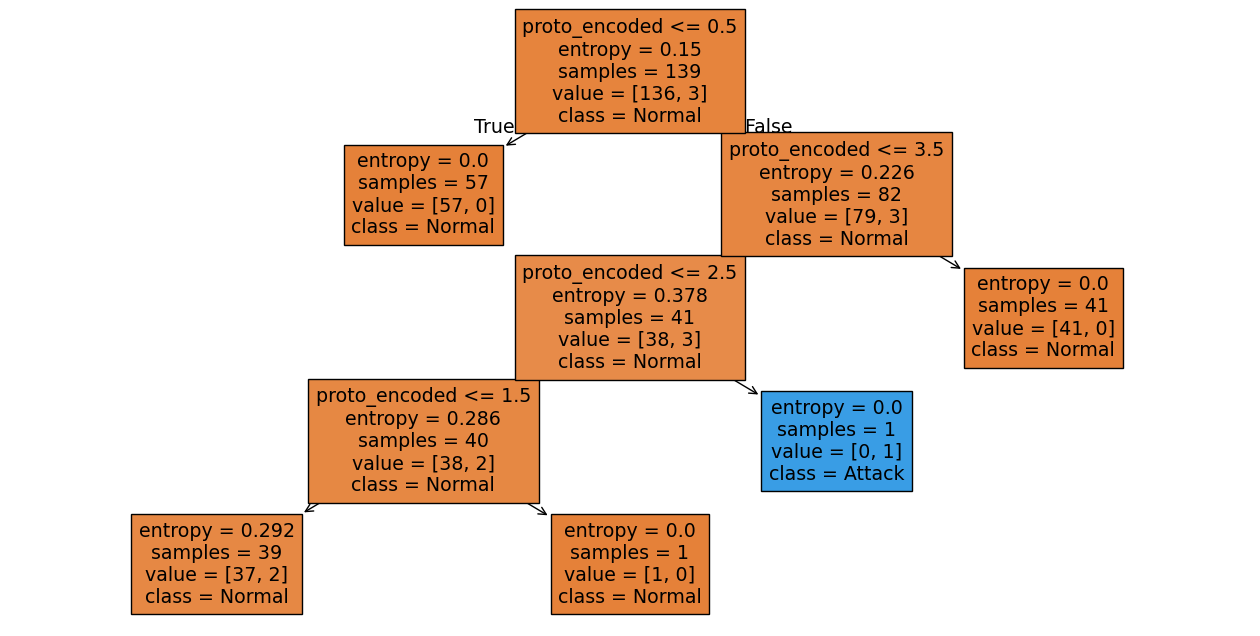

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
tree.plot_tree(clf, feature_names=features, class_names=["Normal", "Attack"], filled=True)
plt.show()

In [ ]:
# Example new packet
# SYN=1, proto=2 (ICMP), count='high' → bin=2
sample = pd.DataFrame([[1, 2, 2]], columns=features)
prediction = clf.predict(sample)[0]

if prediction == 1:
    print("🚨 ID3 Decision Tree Prediction: ATTACK")
else:
    print("✅ ID3 Decision Tree Prediction: NORMAL")

✅ ID3 Decision Tree Prediction: NORMAL


# Visual using Tkinter

In [ ]:
protocols = {
    'TCP': 0,
    'UDP': 1,
    'ICMP': 2,
    'DISCOVER': 3,
    'Other': 4
}

In [ ]:
# Predict for each protocol with SYN=1 and high count (worst-case scenario)

# Open a file to save the results
with open("ID3_results.txt", "w") as f:
    f.write("🔍 Predictions for each protocol using ID3 Decision Tree\n\n")

    for proto_name, proto_code in protocols.items():
        sample = pd.DataFrame([[1, proto_code, 2]], columns=['SYN_Packet', 'proto_encoded', 'count_binned'])
        prediction = clf.predict(sample)[0]
        
        if prediction == 1:
            result = "🚨 ATTACK"
        else:
            result = "✅ NORMAL"
        
        result_text = f"🔍 Protocol: {proto_name} ({proto_code}) → {result}\n"
        
        # Write to file
        f.write(result_text)

print("✅ ID3 Decision Tree results saved to 'ID3_results.txt'!")

✅ ID3 Decision Tree results saved to 'ID3_results.txt'!


In [ ]:
import tkinter as tk
import ttkbootstrap as ttk
import pandas as pd

# Initialize window
app = ttk.Window(themename="superhero")
app.title("Network Attack Detection Project")
app.geometry("1200x700")

# Global Variables
df = None

# Functions
def load_dataset():
    global df
    df = pd.read_csv('output.csv')
    update_treeview()

def update_treeview():
    tree.delete(*tree.get_children())
    tree["column"] = list(df.columns)
    tree["show"] = "headings"

    # Set headings and column widths
    for col in df.columns:
        tree.heading(col, text=col)
        tree.column(col, width=150, anchor="center")  # Adjust width

    # Insert rows into treeview
    for idx, row in df.iterrows():
        tag = 'evenrow' if idx % 2 == 0 else 'oddrow'
        tree.insert("", "end", values=list(row), tags=(tag,))

def show_naive_bayes():
    try:
        with open("Naive_results.txt", "r") as file:
            result = file.read()
        result_text.config(state="normal")
        result_text.delete(1.0, tk.END)
        result_text.insert(tk.END, result)
        result_text.config(state="disabled")
    except FileNotFoundError:
        result_text.config(state="normal")
        result_text.delete(1.0, tk.END)
        result_text.insert(tk.END, "Naive_results.txt not found!")
        result_text.config(state="disabled")

def show_decision_tree():
    try:
        with open("ID3_results.txt", "r") as file:
            result = file.read()
        result_text.config(state="normal")
        result_text.delete(1.0, tk.END)
        result_text.insert(tk.END, result)
        result_text.config(state="disabled")
    except FileNotFoundError:
        result_text.config(state="normal")
        result_text.delete(1.0, tk.END)
        result_text.insert(tk.END, "ID3_results.txt not found!")
        result_text.config(state="disabled")

heading_label = ttk.Label(app, text="Network Attack Detection System", font=("Helvetica", 24, "bold"), bootstyle="primary")
heading_label.pack(pady=10)

# Frames
frame_top = ttk.Frame(app)
frame_top.pack(pady=10)

frame_middle = ttk.Frame(app)
frame_middle.pack(pady=10, fill="both", expand=True)

frame_bottom = ttk.Frame(app)
frame_bottom.pack(pady=10, fill="both", expand=True)

# Buttons
load_btn = ttk.Button(frame_top, text="Load Dataset", command=load_dataset, bootstyle="success-outline")
load_btn.grid(row=0, column=0, padx=10)

nb_btn = ttk.Button(frame_top, text="Show Naive Bayes Result", command=show_naive_bayes, bootstyle="info-outline")
nb_btn.grid(row=0, column=1, padx=10)

dt_btn = ttk.Button(frame_top, text="Show Decision Tree Result", command=show_decision_tree, bootstyle="warning-outline")
dt_btn.grid(row=0, column=2, padx=10)

# Treeview for dataset with scrollbars
tree_frame = ttk.Frame(frame_middle)
tree_frame.pack(fill="both", expand=True)

# Scrollbars
tree_scroll_y = ttk.Scrollbar(tree_frame, orient="vertical")
tree_scroll_y.pack(side="right", fill="y")

tree_scroll_x = ttk.Scrollbar(tree_frame, orient="horizontal")
tree_scroll_x.pack(side="bottom", fill="x")

# Treeview widget
tree = ttk.Treeview(tree_frame, yscrollcommand=tree_scroll_y.set, xscrollcommand=tree_scroll_x.set)
tree.pack(fill="both", expand=True)

# Make treeview look better for dark background (Superhero theme)
tree.configure(bootstyle="dark")  # Use dark style for tree
# Set row colors (darker shades matching dark theme)
tree.tag_configure('oddrow', background='#1f1f1f', foreground='white')  # Dark grey with white text
tree.tag_configure('evenrow', background='#2a2a2a', foreground='white')  # Slightly lighter dark grey with white text

# Attach scrollbars
tree_scroll_y.config(command=tree.yview)
tree_scroll_x.config(command=tree.xview)

# Text box for result output
result_frame = ttk.Frame(frame_bottom)
result_frame.pack(fill="both", expand=True)

result_scroll_y = ttk.Scrollbar(result_frame, orient="vertical")
result_scroll_y.pack(side="right", fill="y")

result_scroll_x = ttk.Scrollbar(result_frame, orient="horizontal")
result_scroll_x.pack(side="bottom", fill="x")

result_text = tk.Text(result_frame, wrap="none", font=("Consolas", 12),
                        yscrollcommand=result_scroll_y.set, xscrollcommand=result_scroll_x.set,
                        bg="#f7f7f7", bd=2, relief="ridge")
result_text.pack(fill="both", expand=True)

# Attach scrollbars
result_scroll_y.config(command=result_text.yview)
result_scroll_x.config(command=result_text.xview)

# Start app
app.mainloop()